## Introduction

在之前的教程里，我们介绍jax与其基本语法框架并快速浏览了其高级自动微分功能(advanced automatic differentiation)。
今天我们将介绍如何用原生态的jax语法来搭建神经网络框架, 具体而言，我们将介绍:
   1. 神经网络框架搭建先决条件之一: random state的处理与设置。
   2. 神经网络框架搭建先决条件之二: pytree结构,用来处理如神经网络模型中的参数集合。
   3. 基于上述两个知识点，搭建一个toy神经网络模型。
   

In [1]:
import numpy as np
import functools

import jax
import jax.numpy as jnp

from jax import grad, jit, vmap, pmap, random

import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple

## The Problem of State
在前面的教程里，我们介绍过: jax采用函数式编程(functional programming)的机制, 相应地，对于随机数生成，我们需要显式地传入状态变量(state)。
在神经网络框架中，我们的诸多元素是和随机数生成状态强相关的，如模型的参数(model parameters), 优化器(optimizer),  又或是batchnorm，layernorm等operator。不同的初始化种子，会使得上述模块初始参数的不同，导致最终结果存在着差异。
在实际神经网络训练中，我们可能希望在多次训练中，每次由不同的种子对网络参数(parameters)等进行随机初始化，以得到不同随机状态(random state)的训练过程与结果。然后进行集成或取测试集里最优的一个。

在jax中，最常用的方法是我们通过split key生成一系列新的key list: **我们对key进行split, split将对原始的状态进行变换操作，生成新的key list**。
如在下述代码中，我们通过split分成两个state:

In [2]:
seed = 0
state = jax.random.PRNGKey(seed)

state1, state2 = jax.random.split(state)  

在实际神经网络模型搭建中，我们通常用类(class)模块进行表示。
对于类(class), 在类里的我们定义的随机性元素,如神经网络的参数,其将随着每次训练迭代参数也将随之更新, 是和随机状态(random state)强关联的;
对其这些元素，我们需要一些key split技巧对其进行处理，以处到我们期望的结果。
我们从一个简单的python计数类(class)的实现入手:

In [3]:
class Counter:
    """A simple counter."""
    def __init__(self):
        self.n = 0
    def count(self) -> int:
        """Increments the counter and returns the new value."""
        self.n += 1
        return self.n
    def reset(self):
        """Resets the counter to zero."""
        self.n = 0

In [4]:
counter = Counter()

for _ in range(3):  # works like a charm
    print(counter.count())

1
2
3


若使用JIT即时编译机制对其进行加速:

In [5]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3): 
    print(fast_count())

1
1
1


我们的每次计数结果都是1; 这是因为, 基于jit的机制，在第一次调用执行时,jax对其进行编译并将结果文件进行caching;而在后续的执行都将使用cache的结果文件并输出相同的结果。
我们可以调用make_jaxpr函数对其cache文件的内部逻辑打印分析:

In [6]:
from jax import make_jaxpr  # let's use jaxpr to understand why this is happening

counter.reset()
print(make_jaxpr(counter.count)())

{ lambda ; . let  in (1,) }


可以看到其caching中的函数机制就是每次返回1。若在上述基础上再调用一次:

In [7]:
from jax import make_jaxpr  # let's use jaxpr to understand why this is happening

counter.reset()
counter.count()
print(make_jaxpr(counter.count)())

{ lambda ; . let  in (2,) }


那该如何我们想实现JIT加速机制的同时又达到原始python代码顺序计数结果？
**解决方案**: 将状态(state)作为参数传入到模型函数里。
如在在上述计数类例子，我们可以将计数状态(counter state)作为函数的参数传入到该类中:

In [8]:
# Solution:
CounterState = int # our counter state is implemented as a simple integer

class CounterV2:
    def count(self, n: CounterState) -> Tuple[int, CounterState]:
        # You could just return n+1, but here we separate its role as the output and as the counter state for didactic purpose.
        # as the output may be some arbitrary function of state in general case
        return n+1, n+1

    def reset(self) -> CounterState:
        return 0

在上述实现中:   
   1. 函数每次返回两个值，第一个是我们关心的结果值(value)，第二个是状态量(state)。
   2. 在每一次loop中，上一次的state作为参数传入；返回一个新的的state,作为下一次loop的状态参数。
   
python版本:

In [13]:
counter = CounterV2()
state = counter.reset()  # notice how reset() now returns state (external vs internal imp)  
for _ in range(3):  
    value, state = counter.count(state)  # looks familiar?
    print(value)  

1
2
3


我们接下来使用JIT即时编译加速版本:

In [8]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):  # nice, working as expected!
    value, state = fast_count(state)
    print(value)

1
2
3


可以看到，现在jit编译后得到我们所预期的结果。

我们现在对上述的测试进行总结，得到在jax 类中一个通用的state使用的方式:

**在经典的python编程框架里，状态量(state)被放在函数内部**
```python
class StatefulClass

    state: State

    def stateful_method(*args, **kwargs) -> Output:
```
**在jax中，我们需要把状态量移至函数的参数列表里**,

```python
class StatelessClass

    def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```
好了，我们完成了构建神经网络模型框架的第一个准备工作: 状态变量的处理。
我们接下来学习pytree数据结构。

## pytree数据结构
### pytree: motivation
我们先从之前的toy优化问题开始: "对包含四个参数的函数求解其最小值"。我们定义如下toy二次函数:
$$
f(x,y,z,w)=x^2+y^2+z^2+w^2\\
$$
用python lambda函数表示:

In [9]:
f = lambda x, y, z, w: x**2 + y**2 + z**2 + w**2 

对于该函数，若用随机梯度下降(stochastic gradient descent)算法对其进行求解:
   1. 初始化其参数权重，我们这里先初始化为(1,1,1,1)).
   2. 通过jax里的grad函数对当前状态与参数进行梯度计算，然后基于梯度下降法对参数进行迭代更新: $\theta = \theta - lr * \nabla \theta$

In [10]:
#初始化模型参数 parameter weight
x, y, z, w = [1.]*4 
#通过grad函数模块计算梯度(偏导)
#默认只返回第一个，所以这里argnums我们显式地定义4个
dfdx, dfdy, dfdz, dfdw = grad(f, argnums=(0, 1, 2, 3))(x, y, z, w)
print(dfdx, dfdy, dfdz, dfdw)

# 通过梯度下降方法更新我们的参数
lr = 0.001
x -= lr*dfdx
y -= lr*dfdy
z -= lr*dfdz
w -= lr*dfdw     

2.0 2.0 2.0 2.0


上述是一个简单的只包含四个参数的toy example, 但若按这样的方式，在如GPT模型( 175B的参数量)，我们可能需要写175B行的代码:

In [11]:
#Great now we just need to update our params!
lr = 0.001
x -= lr*dfdx
y -= lr*dfdy
#... (175B lines later)
w -= lr*dfdw

我们需要一种更好表征方式:可以很自然将大规模的参数集合打包成更复杂的数据结构(如字典型:dictionary)。
在jax里，用以处理这类任务的数据结构就是pytree。

**一个pytree的数据结构可以看成是包含叶子结点和另外pytree子结构的容器(container)**
我们可以看成这定义本身就包含了递归的含义。

在pytree容器里，我们可以包含list, tuples, dict甚至另一个pytree等更复杂的子结构。我们接下来看一个例子:

In [12]:
# A contrived example for pedagogical purposes
#我们可以将其看成是NN模型的参数
from jax.tree_util import tree_leaves
pytree_example = [
    [1,'a', object()],
    [1,(2,3),()],
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
     {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]
# Let's see how many leaves they have:
for pytree in pytree_example:
    leaves = tree_leaves(pytree)  # handy little function
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")
     

[1, 'a', <object object at 0x7f7c2402b4a0>]   has 3 leaves: [1, 'a', <object object at 0x7f7c2402b4a0>]
[1, (2, 3), ()]                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


上述pytree的例子包含三个子pytree的结构，一个dict结构与一个jnp。那我们如何对一个pytree结构进行修改与调整呢?我们这里展示两种方法:
   
   1. 结合tree_map与单参数的lambda函数的方式。
   2. 结合tree_map与双参数的lambda函数的方式。

**单参数的lambda函数方式**

In [13]:
list_of_lists = [
    {'a': 3},
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]
# For single arg functions use tree_map
# tree_map iterates through leaves and applies the lambda function
print(jax.tree_map(lambda x: x*2, list_of_lists)) 

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


**双参数的lambda函数:**

In [14]:
another_list_of_lists = list_of_lists
print(jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists))
## 结果 [{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


**注意**，对于这类方式,我们需要两边的pytree结构是一致的;如不一致，将报错:

In [15]:
# PyTrees need to have the same structure if we are to apply tree_multimap!
another_list_of_lists = deepcopy(list_of_lists)
another_list_of_lists.append([23])
print(jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists))

ValueError: List arity mismatch: 5 != 4; list: [{'a': 3}, [1, 2, 3], [1, 2], [1, 2, 3, 4], [23]].

## A toy MLP Model
好了，我们现在已经学会了:
   1. 如何处理jax中的random state机制与在设计模型时的解决方案。
   2. 如何用pytree组织如神经网络里大规模的参数集合。

可以着手搭建一个小型的神经网络框架并尝试训练该模型。

我们先来定义一个简单的神经网络MLP(multi-layer perceptron)框架代码:在后继的代码里我们再加上随机状态

In [17]:
def init_mlp_params(layer_widths):
    params = []
    # Allocate weights and biases (model parameters)
    # Notice: we're not using JAX's PRNG here - doesn't matter for this simple example
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                biases=np.ones(shape=(n_out,))))
    return params

In [18]:
# Instantiate a single input - single output, 3 layer (2 hidden layers) deep MLP
params = init_mlp_params([1, 128, 128, 1])

# Another example of how we might use tree_map - verify that shapes make sense:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

接下来,基于先前对神经网络知识的了解，我们增加其所需的其他元素:
    
   1. 前向传播模块(forward propagation module), 对于我们的输入X,每一层layer都基于如下公式计算: $Z = weights * inputs + bias $
   2. 损失函数(loss function), 我们这里定义均方差误差: $\mathcal{L} =\mathbb{E}[ (\hat{y}-y)^2]$.
   3. 学习率(learning rate): lr.
   4. update函数: 基于随机梯度下降(SGD:  stochastic gradient descent)更新我们的模型参数。

In [19]:
lr = 0.0001  
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer["weights"]) + layer["biases"])
    return jnp.dot(x, last["weights"]) + last["biases"]

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x)-y) **2) # MSE loss
 
@jit  
def update(params, x, y):

    # Note that grads is a pytree with the same structure as params.
    # grad is one of the many JAX functions that has built-in support for pytrees!
    grads = jax.grad(loss_fn)(params, x, y)


    # SGD update
    return jax.tree_map(
        lambda p, g: p - lr * g, params, grads  # for every leaf i.e. for every param of MLP
    )

接下来我们生成一份简单的仿真数; 用上述函数模块组装成一个神经网络框架来，学习我们模型的参数:

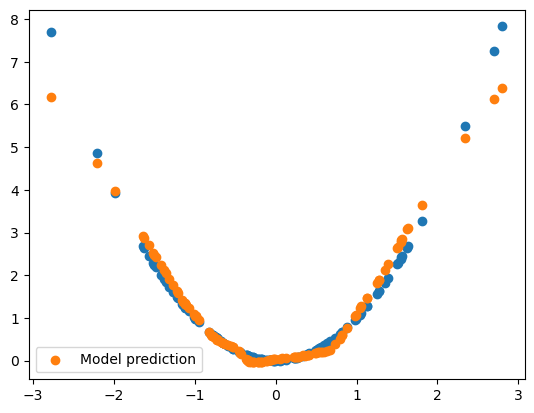

In [20]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 2  # let's learn how to regress a parabola

# Task experiment a bit with other functions (polynomials, sin, etc.)

num_epochs = 5000
for _ in range(num_epochs):
    params = update(params, xs, ys)  # again our lovely pattern

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

好了，我们实现了第一个基于jax的神经网络模型(虽然很简单)。